In [1]:
import numpy as np
import torch
from pathlib import Path
import os
import sys
sys.path.append('../')

# from orbit_datasets import neworbits, versatileorbits, staticorbits
from ldcl.data import neworbits, versatileorbits, staticorbits

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# https://plotly.com/python/creating-and-updating-figures/
import plotly.graph_objects as go

from mpl_toolkits import mplot3d

In [3]:
from ldcl.data import physics

In [20]:
def applyNetworks(locations, config):
    net_list = [torch.load(Path(x), map_location = torch.device('cpu')) for x in locations]
    for net in net_list:
        net.eval()
    
    orbits_dataset, folder = physics.get_dataset(config, "../../saved_datasets")
    
    orbits_loader = torch.utils.data.DataLoader(
        dataset = orbits_dataset,
        shuffle = True,
        batch_size = 1,
        )
    
    network_outputs_list = []
    target_values = []

    for it, (input1, input2, y) in enumerate(orbits_loader):
        out = input1.float()
        for f in net_list:
            out = f(out)
        network_outputs_list.append(out.detach().numpy()[0])

        #append conserved quantities to the end of the representation for plotting, y = (1, )
        #[2=phi0,3=energy,4=angular_momentum] discard [0=eccentricity, 1=semimajor_axis]
        target_values.append(np.array([y['phi0'].detach().numpy().flatten()[0],
                                       y['H'].detach().numpy().flatten()[0],
                                       y['L'].detach().numpy().flatten()[0]
                                      ]))
    network_outputs = np.vstack(network_outputs_list)
    target_values = np.vstack(target_values)

    phi0_c_values = target_values[:,0]
    energy_c_values = target_values[:,1]
    angular_momentum_c_values = target_values[:,2]
    
    return network_outputs, [phi0_c_values, energy_c_values, angular_momentum_c_values]

In [21]:
def singleOrbit(locations, config):
    """
    assumes config has num_trajs = 1
    """
    orbits_dataset, folder = physics.get_dataset(config, "../../saved_datasets")
    
    orbit = orbits_dataset.data
    
    #print(orbit.shape[1:])
    assert orbit.shape[0] == 1, f'{config} has num_traj = {orbit.shape[0]}, expected 1'
    
    orbit = orbit.reshape(orbit.shape[1:])
    
    net_list = [torch.load(Path(x), map_location = torch.device('cpu')) for x in locations]
    for net in net_list:
        net.eval()
    
    out = torch.from_numpy(orbit).float()
    
    for f in net_list:
        out = f(out)
    
    network_outputs = out.detach().numpy()
    
    return network_outputs
    # print(orbit.shape)

In [25]:
def general_plot(locations, config1, color_idx, config2 = None):
    """
    locations: iterable of file paths to apply on data
    config1: file path to config file for the data to be plotted
    color_idx: 0,1,2 (phi_0, energy, angular momentum respectively) to plot with the desired coloring
    config2: file path to config file for the single orbit to be plotted, IMPORTANT: expects num_trajs = 1 in this single orbit file
    
    given some neural networks to pass the data through,
    creates plotly graph object that visualizes embeddings as well as a single orbit in the embedding space
    """
    network_outputs, conserved_quantities = applyNetworks(locations, config1)
    annotations = [f'phi_0: {p:.3f}, H: {h:.3f}, L: {l:.3f}' for (p,h,l) in zip(*conserved_quantities)]
    
    if config2 is not None:
        single_orbit = singleOrbit(locations, config2)
    
    data = []
    
    plot1 = go.Scatter3d(
        x=network_outputs[:, 0],
        y=network_outputs[:, 1],
        z=network_outputs[:, 2],
        mode='markers',
        text = annotations,
        marker=dict(
            size=4,
            color=conserved_quantities[color_idx], # 0 for angle, 1 for energy, 2 for angular momentum
            colorscale='viridis',
            opacity=1,
            line=dict(width=1, color='black'),
            showscale = True
        )
    )
    data.append(plot1)
    
    if config2 is not None:
        plot2 = go.Scatter3d(
            x=single_orbit[:, 0],
            y=single_orbit[:, 1],
            z=single_orbit[:, 2],
            mode='markers',
            #text = annotations,
            marker=dict(
                size=4,
                #color=conserved_quantities[color_idx], # 0 for angle, 1 for energy, 2 for angular momentum
                #colorscale='viridis',
                opacity=1,
                line=dict(width=1, color='black'),
                #showscale = True
            )
        )
        data.append(plot2)
    
    
    fig = go.Figure(data = data, layout = go.Layout(height = 800, width = 1000))
    
    fig.show()

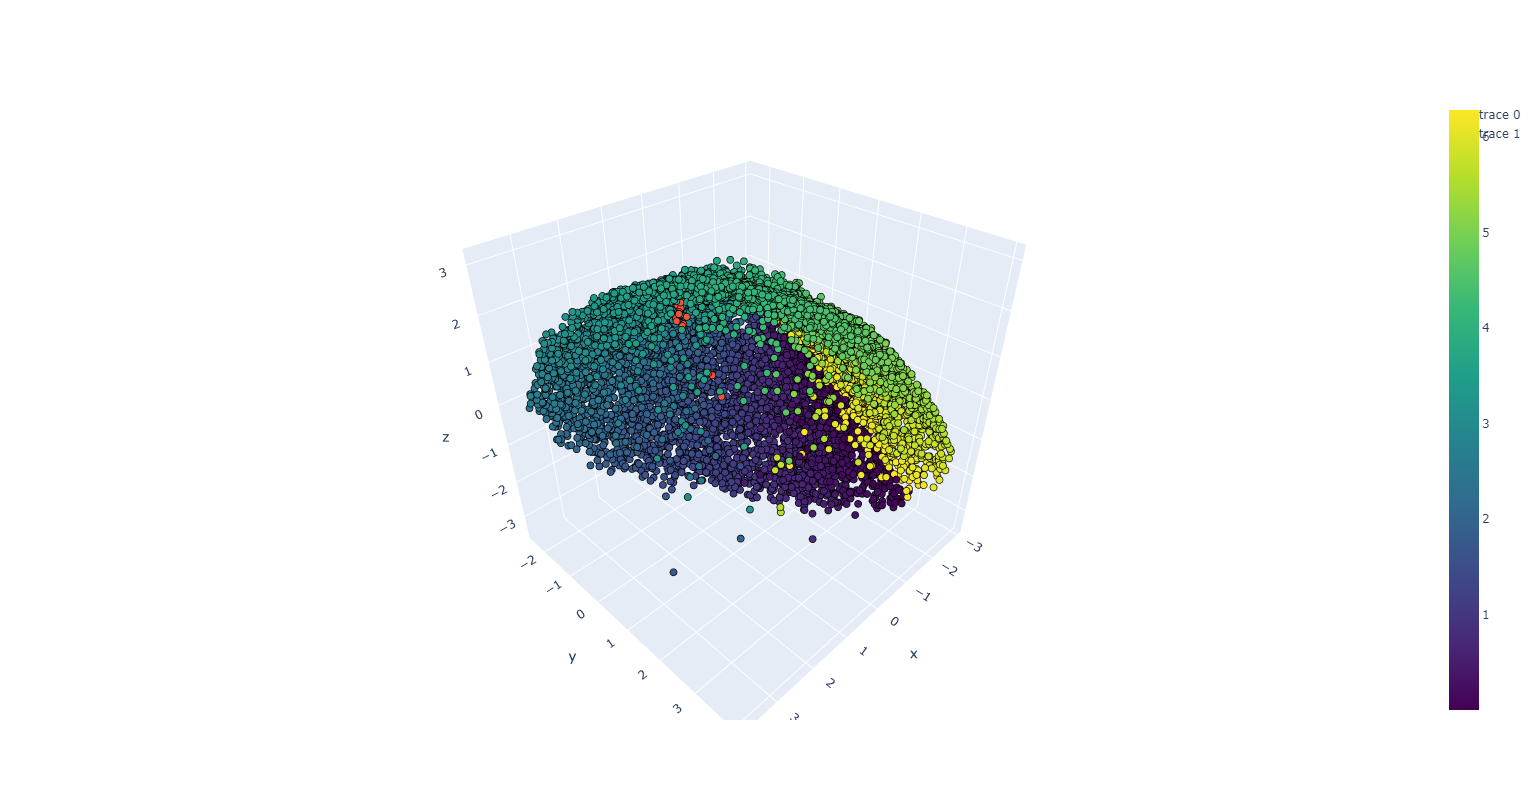

In [26]:
general_plot(["../saved_models/simclr_test1/final_encoder.pt"], '../data_configs/orbit_config_default.json', color_idx = 0, config2 = '../single_orbit.json')